# 1 Imports

## 1.1 Librairies

In [4]:
import os
os.environ["OMP_NUM_THREADS"] = '5'
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from sklearn import manifold, cluster, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from keras.models import Model
from keras.layers import *
from transformers import BertTokenizer, BertModel, AutoTokenizer
import gensim
import torch
import tensorflow_hub as hub

### 1.1.1 Options

In [5]:
pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

sns.set()

In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WALID\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WALID\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WALID\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1.2 Data

In [7]:
df = pd.read_csv('data/data.csv')
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.00,899.00,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.00,449.00,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.00,1299.00,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.00,698.00,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

## 1.3 Reporting

In [9]:
# data_profiling = ProfileReport(df, title="EDA sample flipkart")
# data_profiling.to_file('report/eda_report.html')

Le rapport initial de l'EDA nous apporte plusieurs infos.

**Les types de variables (15 au total)** :
- 9 variables textuelles
- 1 variable temporelle
- 2 variables numériques
- 1 variable boolean
- 2 variables catégorielles

**Complément d'infos** :
- Les données vont du 01/12/2015 au 26/06/2016
- Il y a 1050 lignes
- Il y a 341 valeurs nulles (ce qui représente 2.2% des données)
- La variable **Brand** est en majorité responsable de ça (338 valeurs nulles)
- La variable **is_FK_Advantage_product** est **False** pour 94.6% des données
- 84.7% des données n'ont pas de note présente dans **product/overall_rating**
- Aucune ligne dupliquée n'est présente

Au niveau des corrélations, il y a quelques variables très corrélées entre elles :
- **discounted_price** et **retail_price**
- **overall_rating** et **product_rating**

# 2. Nettoyage

## 2.1 Suppression de colonnes

In [10]:
df.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [11]:
# Suppression des colonnes inutiles pour ce projet
columns_to_drop = [
    'crawl_timestamp', 'product_url', 'pid',
    'retail_price', 'discounted_price', 'is_FK_Advantage_product',
    'product_rating', 'overall_rating', 'product_specifications'
]

df.drop(columns=columns_to_drop, inplace=True)
df.head()

,uniq_id,product_name,product_category_tree,image,description,brand
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print


## 2.2 product_category_tree

Cette variable contient des informations importantes mais la structure n'est pas adéquate pour la classification, on va transformer cette variable pour que ça soit plus utilisable.

In [12]:
df['product_category_tree'].unique().tolist()

['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
 '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
 '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
 '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
 '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
 '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
 '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
 '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
 '["Watches >> Wrist Watches >> TAG Heuer Wrist Watches"]',
 '["Watches >> Wrist Watches >> C

### 2.2.1 Création de trois variables de niveau

In [13]:
category_levels_count = df['product_category_tree'].apply(lambda x: len(x.split('>>')))
max_categories = category_levels_count.max()
max_categories

7

In [14]:
# On commence par enlever les crochets et les guillemets
df['product_category_tree'] = df['product_category_tree'].str.strip('["]')

category_columns = ['category_level_1', 'category_level_2', 'category_level_3', 
                    'category_level_4', 'category_level_5', 'category_level_6',
                    'category_level_7']


# On divise en trois colonnes pour assigner un niveau de catégorie
df[category_columns] = df['product_category_tree'].str.split('>>', expand=True).iloc[:, :7]

df.drop(columns=['product_category_tree'], inplace=True)
df.head()

,uniq_id,product_name,image,description,brand,category_level_1,category_level_2,category_level_3,category_level_4,category_level_5,category_level_6,category_level_7
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,None,None,None
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",None,None
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,None,None
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,None,None
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,None,None


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniq_id           1050 non-null   object
 1   product_name      1050 non-null   object
 2   image             1050 non-null   object
 3   description       1050 non-null   object
 4   brand             712 non-null    object
 5   category_level_1  1050 non-null   object
 6   category_level_2  1050 non-null   object
 7   category_level_3  1047 non-null   object
 8   category_level_4  679 non-null    object
 9   category_level_5  405 non-null    object
 10  category_level_6  127 non-null    object
 11  category_level_7  57 non-null     object
dtypes: object(12)
memory usage: 98.6+ KB


## 2.3 Brand

In [16]:
df.loc[df['brand'].isna()]

,uniq_id,product_name,image,description,brand,category_level_1,category_level_2,category_level_3,category_level_4,category_level_5,category_level_6,category_level_7
5,893aa5ed55f7cff2eccea7758d7a86bd,Maserati Time R8851116001 Analog Watch - For ...,893aa5ed55f7cff2eccea7758d7a86bd.jpg,Maserati Time R8851116001 Analog Watch - For ...,NaN,Watches,Wrist Watches,Maserati Time Wrist Watches,None,None,None,None
6,f355cc1ccb08bd0d283ed979b7ee7515,"Camerii WM64 Elegance Analog Watch - For Men,...",f355cc1ccb08bd0d283ed979b7ee7515.jpg,"Camerii WM64 Elegance Analog Watch - For Men,...",NaN,Watches,Wrist Watches,Camerii Wrist Watches,None,None,None,None
7,dd0e3470a7e6ed76fd69c2da27721041,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,dd0e3470a7e6ed76fd69c2da27721041.jpg,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,NaN,Watches,Wrist Watches,T STAR Wrist Watches,None,None,None,None
8,41384da51732c0b4df3de8f395714fbb,"Alfajr WY16B Youth Digital Watch - For Men, Boys",41384da51732c0b4df3de8f395714fbb.jpg,"Alfajr WY16B Youth Digital Watch - For Men, B...",NaN,Watches,Wrist Watches,Alfajr Wrist Watches,None,None,None,None
9,710ed5f2393a4b9e8823aa0029f71f93,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,710ed5f2393a4b9e8823aa0029f71f93.jpg,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,NaN,Watches,Wrist Watches,TAG Heuer Wrist Watches,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
924,a618354ba17cff64826558d81afc77ab,Elfani Brilliance Lip Color 3.5 g,a618354ba17cff64826558d81afc77ab.jpg,Flipkart.com: Buy Elfani Brilliance Lip Color ...,NaN,Beauty and Personal Care,Makeup,Lips,Lipsticks,Elfani Lipsticks,None,None
935,7b1c5edc85bc7e31edf49ab70034bb3a,Incolor Metalic Lipstick N15 3.8 g,7b1c5edc85bc7e31edf49ab70034bb3a.jpg,Flipkart.com: Buy Incolor Metalic Lipstick N15...,NaN,Beauty and Personal Care,Makeup,Lips,Lipsticks,Incolor Lipsticks,None,None
946,2cc24452688ed35dfbff566e22e53c95,Organistick Silver Label Lipstick 10 g,2cc24452688ed35dfbff566e22e53c95.jpg,Flipkart.com: Buy Organistick Silver Label Lip...,NaN,Beauty and Personal Care,Makeup,Lips,Lipsticks,Organistick Lipsticks,None,None
985,edb97bd2433fd9de301c8a44344777bb,Artist Haat Vanity Box Makeup and Jewellery Va...,edb97bd2433fd9de301c8a44344777bb.jpg,Artist Haat Vanity Box Makeup and Jewellery Va...,NaN,Beauty and Personal Care,Makeup,Vanity Boxes,Artist Haat Vanity Boxes,None,None,None


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniq_id           1050 non-null   object
 1   product_name      1050 non-null   object
 2   image             1050 non-null   object
 3   description       1050 non-null   object
 4   brand             712 non-null    object
 5   category_level_1  1050 non-null   object
 6   category_level_2  1050 non-null   object
 7   category_level_3  1047 non-null   object
 8   category_level_4  679 non-null    object
 9   category_level_5  405 non-null    object
 10  category_level_6  127 non-null    object
 11  category_level_7  57 non-null     object
dtypes: object(12)
memory usage: 98.6+ KB


In [18]:
df.fillna('Non spécifié', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   uniq_id           1050 non-null   object
 1   product_name      1050 non-null   object
 2   image             1050 non-null   object
 3   description       1050 non-null   object
 4   brand             1050 non-null   object
 5   category_level_1  1050 non-null   object
 6   category_level_2  1050 non-null   object
 7   category_level_3  1050 non-null   object
 8   category_level_4  1050 non-null   object
 9   category_level_5  1050 non-null   object
 10  category_level_6  1050 non-null   object
 11  category_level_7  1050 non-null   object
dtypes: object(12)
memory usage: 98.6+ KB


In [19]:
df.head()

,uniq_id,product_name,image,description,brand,category_level_1,category_level_2,category_level_3,category_level_4,category_level_5,category_level_6,category_level_7
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet...,Non spécifié,Non spécifié,Non spécifié
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",Non spécifié,Non spécifié
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels,Eurospa Cotton Terry Face Towel Set (20 PIECE...,Non spécifié,Non spécifié
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets,SANTOSH ROYAL FASHION Cotton Printed King siz...,Non spécifié,Non spécifié
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets,Jaipur Print Cotton Floral King sized Double ...,Non spécifié,Non spécifié


# 3. Prétraitement du texte

Le nettoyage est fait, on va pouvoir commencer à prétraiter les données textuelles. Il y a en partie plusieurs objectifs liés à ce prétraitement :
- Transformer le texte en minuscule
- Supprimer les ponctuations et mots de liaison
- Tokeniser
- Lemmatiser/Stemmer

## 3.1 Fonctions de traitement

In [20]:
def plot_tokens_frequencies(df, column_name, top_n=20):
    # Extraire tous les tokens d'une colonne
    tokens = [token for tokens_list in df[column_name] for token in tokens_list]
    
    # Compter la fréquence de chaque token
    token_counts = Counter(tokens)

    # Obtenir les top tokens les plus fréquents
    most_common_tokens = token_counts.most_common(top_n)
    tokens, frequencies = zip(*most_common_tokens)

    # Création d'un barplot pour les tokens les plus fréquents (top_n)
    plt.figure(figsize=(12, 6))
    plt.bar(tokens, frequencies)
    plt.title(f"Top {top_n} des tokens les plus fréquents dans {column_name}")
    plt.xlabel('Token')
    plt.ylabel('Fréquence')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [21]:
def tokenizer_fct(sentence) :
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

In [22]:
additional_stop_words = ['key', 'features', 'specifications']
stop_words = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')'] + additional_stop_words

In [23]:
# lower case et alpha
def lower_start_fct(list_words) :
    lower_word = [word.lower() for word in list_words if (not word.startswith("@")) 
                                       and (not word.startswith("http"))]
    return lower_word

In [24]:
def stop_word_filter_fct(list_words) :
    filtered_words = [word for word in list_words if not word in stop_words]
    filtered_words2 = [word for word in filtered_words if len(word) > 2]
    return filtered_words2

In [25]:
def clean_and_tokenize(text):
    tokens = tokenizer_fct(text)
    tokens = lower_start_fct(tokens)
    tokens = stop_word_filter_fct(tokens)

    return tokens

In [26]:
def stem_text(list_words):
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in list_words]
    return stemmed_words

In [27]:
def lemmantize_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lemantize_word = [lemmatizer.lemmatize(word) for word in list_words]
    return lemantize_word

In [28]:
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text)
    lower_word = lower_start_fct(word_tokens)
    filtered_words = stop_word_filter_fct(lower_word)
    lemmatize_word = lemmantize_fct(filtered_words)
    transf_desc_text = ' '.join(lemmatize_word)
    return transf_desc_text

In [29]:
def ARI_fct(features, true_labels, num_clusters):
    time1 = time.time()

    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random',
                        learning_rate=200, random_state=42)

    X_tsne = tsne.fit_transform(features)

    clusters = cluster.KMeans(n_clusters=num_clusters, n_init=100, random_state=42)
    clusters.fit(X_tsne)

    ARI = np.round(metrics.adjusted_rand_score(true_labels, clusters.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print(f"ARI : {ARI} - Time : {time2}s")

    return ARI, X_tsne, clusters.labels_

In [30]:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, category_names):
    fig = plt.figure(figsize=(12, 6))

    # Visualisation selon les catégories réelles
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=category_names, loc='best', title='Categorie')
    plt.title("Représentation des données par catégories réelles")

    # Visualisation selon les clusters obtenus
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    unique_clusters = sorted(set(labels))
    ax.legend(
        handles=scatter.legend_elements()[0], 
        labels=[f"Cluster {i}" for i in unique_clusters],
        loc="best",
        title="Clusters")

    plt.title("Représentation des données par clusters")

    plt.tight_layout()
    plt.show()
    print(f"ARI : {ARI}")

### 3.1.1 Clean and tokenize

In [31]:
df['cleaned_tokens'] = df['description'].apply(clean_and_tokenize)
df[['description', 'cleaned_tokens']].head()

,description,cleaned_tokens
0,Key Features of Elegance Polyester Multicolor ...,"[elegance, polyester, multicolor, abstract, ey..."
1,Specifications of Sathiyas Cotton Bath Towel (...,"[sathiyas, cotton, bath, towel, bath, towel, r..."
2,Key Features of Eurospa Cotton Terry Face Towe...,"[eurospa, cotton, terry, face, towel, set, siz..."
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[santosh, royal, fashion, cotton, printed, kin..."
4,Key Features of Jaipur Print Cotton Floral Kin...,"[jaipur, print, cotton, floral, king, sized, d..."


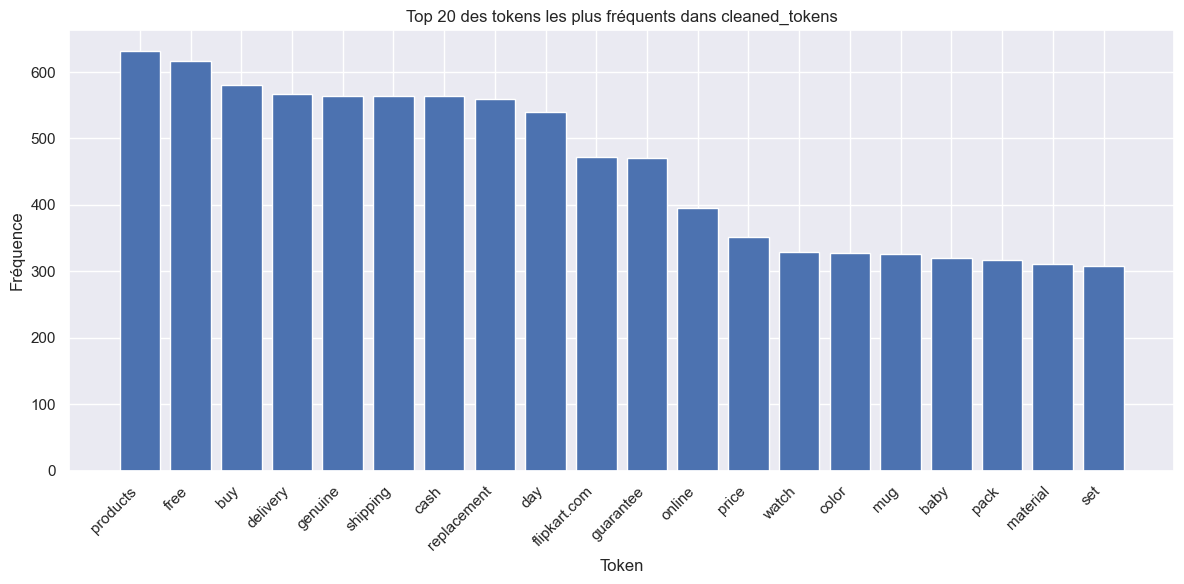

In [32]:
plot_tokens_frequencies(df, 'cleaned_tokens', top_n=20)

### 3.1.2 Stemmer

In [33]:
df['stemmed_tokens'] = df['cleaned_tokens'].apply(stem_text)
df[['cleaned_tokens', 'stemmed_tokens']].head()

,cleaned_tokens,stemmed_tokens
0,"[elegance, polyester, multicolor, abstract, ey...","[eleg, polyest, multicolor, abstract, eyelet, ..."
1,"[sathiyas, cotton, bath, towel, bath, towel, r...","[sathiya, cotton, bath, towel, bath, towel, re..."
2,"[eurospa, cotton, terry, face, towel, set, siz...","[eurospa, cotton, terri, face, towel, set, siz..."
3,"[santosh, royal, fashion, cotton, printed, kin...","[santosh, royal, fashion, cotton, print, king,..."
4,"[jaipur, print, cotton, floral, king, sized, d...","[jaipur, print, cotton, floral, king, size, do..."


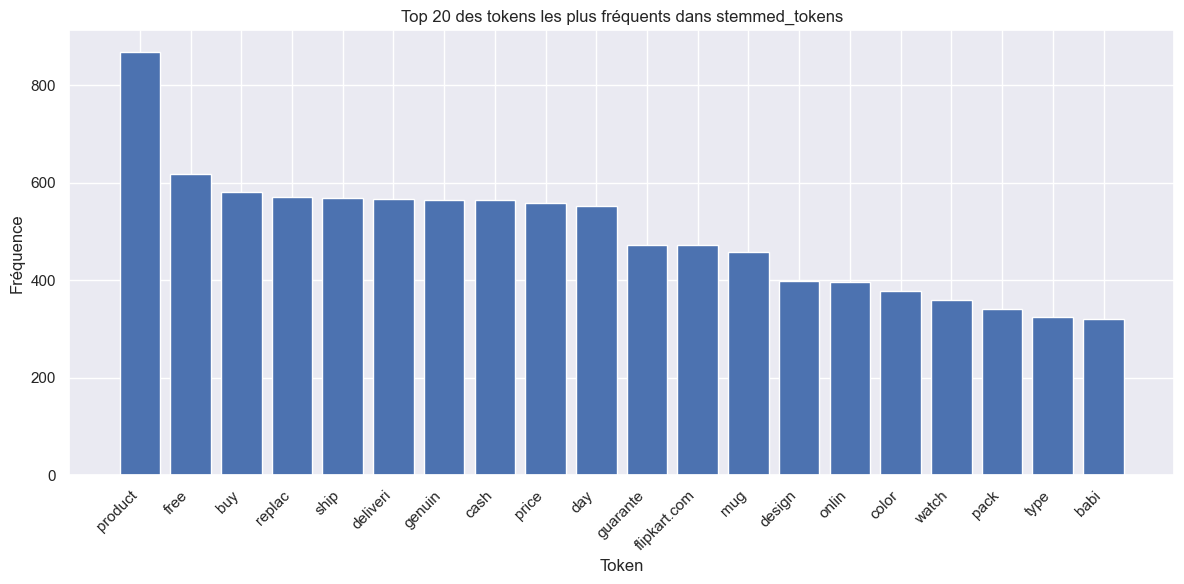

In [34]:
plot_tokens_frequencies(df, 'stemmed_tokens', top_n=20)

### 3.1.3 Lemantize

In [35]:
df['lemmatized_tokens'] = df['cleaned_tokens'].apply(lemmantize_fct)
df[['cleaned_tokens', 'lemmatized_tokens']].head()

,cleaned_tokens,lemmatized_tokens
0,"[elegance, polyester, multicolor, abstract, ey...","[elegance, polyester, multicolor, abstract, ey..."
1,"[sathiyas, cotton, bath, towel, bath, towel, r...","[sathiyas, cotton, bath, towel, bath, towel, r..."
2,"[eurospa, cotton, terry, face, towel, set, siz...","[eurospa, cotton, terry, face, towel, set, siz..."
3,"[santosh, royal, fashion, cotton, printed, kin...","[santosh, royal, fashion, cotton, printed, kin..."
4,"[jaipur, print, cotton, floral, king, sized, d...","[jaipur, print, cotton, floral, king, sized, d..."


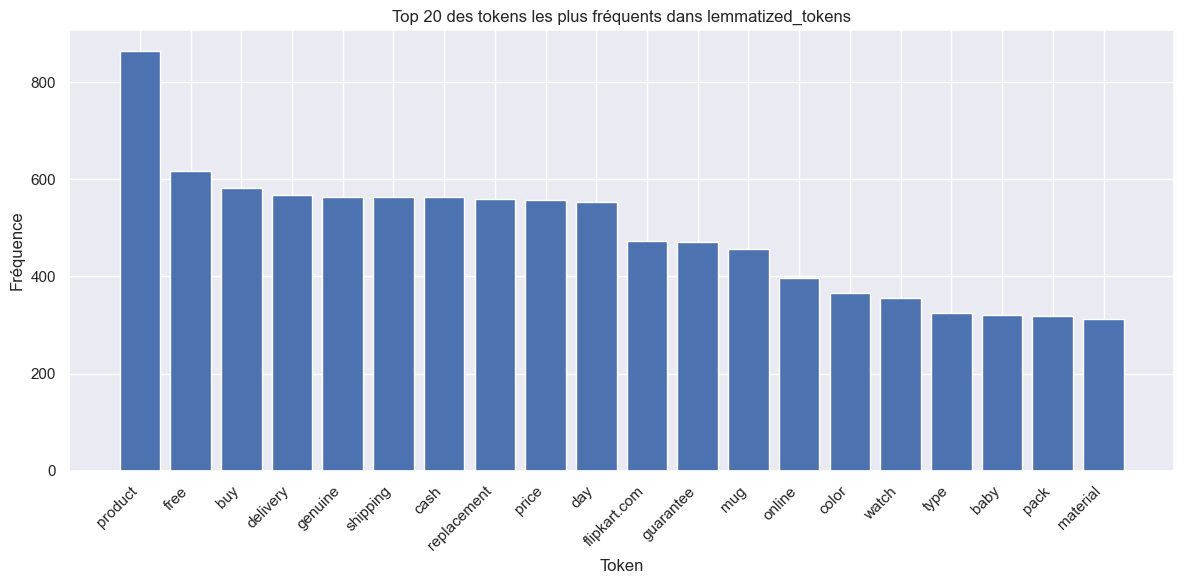

In [36]:
plot_tokens_frequencies(df, 'lemmatized_tokens', top_n=20)

### 3.1.4 Seuil de fréquence 

In [37]:
all_tokens = [token for tokens_list in df['lemmatized_tokens'] for token in tokens_list]
token_counts = Counter(all_tokens)

token_counts_df = pd.DataFrame(token_counts.items(), columns=['token', 'frequency'])
token_counts_df = token_counts_df.sort_values(by='frequency', ascending=False)

token_counts_df.head(50)

,token,frequency
134,product,863
246,free,617
235,buy,581
249,delivery,567
247,shipping,564
242,genuine,564
248,cash,564
244,replacement,559
11,price,558
243,day,553


In [38]:
token_counts_df.tail(20)

,token,frequency
3283,gray,1
3324,besides,1
3285,coloring,1
3286,after.,1
3287,colorant,1
3289,1conditioner,1
3294,633btp_yx3k,1
3295,666btp_xn,1
3297,dsco,1
3299,643,1


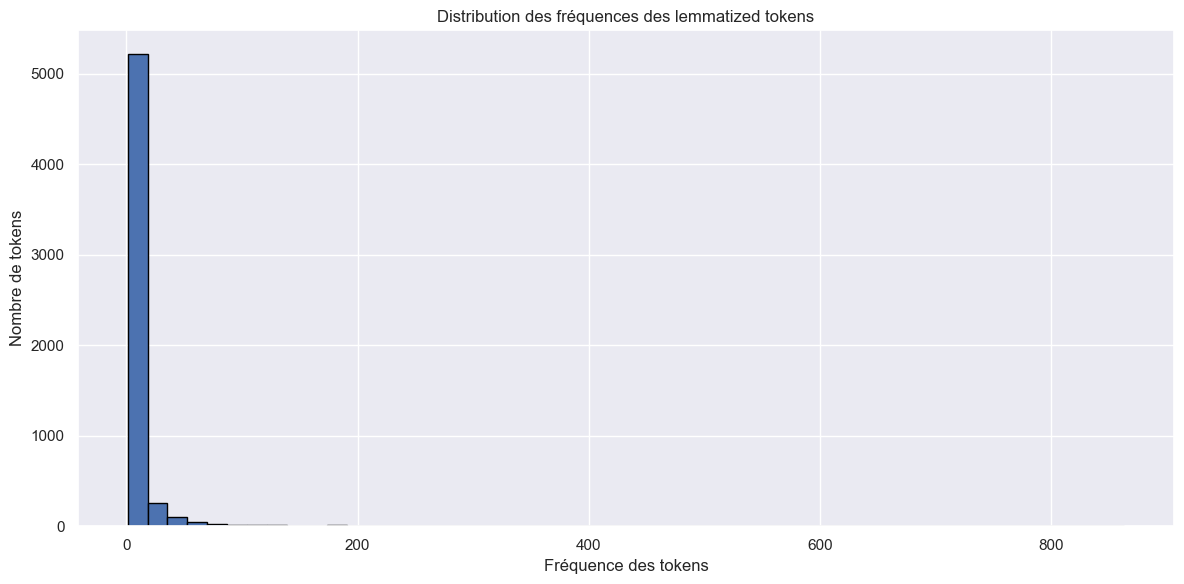

In [39]:
plt.figure(figsize=(12, 6))
plt.hist(token_counts_df['frequency'], bins=50, edgecolor='black')
plt.title('Distribution des fréquences des lemmatized tokens')
plt.xlabel('Fréquence des tokens')
plt.ylabel('Nombre de tokens')
plt.tight_layout()
plt.show()

In [40]:
min_threshold = 5
max_threshold = 470

valid_tokens = {token for token, count in token_counts.items() if min_threshold <= count <= max_threshold}

def filter_tokens(tokens):
    return [token for token in tokens if token in valid_tokens]

df['filtered_tokens'] = df['lemmatized_tokens'].apply(filter_tokens)

df[['lemmatized_tokens', 'filtered_tokens']].head(10)

,lemmatized_tokens,filtered_tokens
0,"[elegance, polyester, multicolor, abstract, ey...","[elegance, polyester, multicolor, abstract, ey..."
1,"[sathiyas, cotton, bath, towel, bath, towel, r...","[cotton, bath, towel, bath, towel, red, yellow..."
2,"[eurospa, cotton, terry, face, towel, set, siz...","[eurospa, cotton, terry, face, towel, set, siz..."
3,"[santosh, royal, fashion, cotton, printed, kin...","[santosh, royal, fashion, cotton, printed, kin..."
4,"[jaipur, print, cotton, floral, king, sized, d...","[jaipur, print, cotton, floral, king, sized, d..."
5,"[maserati, time, r8851116001, analog, watch, b...","[time, analog, watch, boy, time, analog, watch..."
6,"[camerii, wm64, elegance, analog, watch, men, ...","[elegance, analog, watch, men, boy, elegance, ..."
7,"[star, uft, tsw, 005, analog, watch, boy, pric...","[analog, watch, boy, 399, whether, way, work, ..."
8,"[alfajr, wy16b, youth, digital, watch, men, bo...","[digital, watch, men, boy, digital, watch, men..."
9,"[tag, heuer, cau1116.ba0858, formula, analog, ...","[analog, watch, boy, men, analog, watch, boy, ..."


In [41]:
list_categories = list(set(df['category_level_1']))
print(list_categories)

['Home Furnishing ', 'Beauty and Personal Care ', 'Watches ', 'Home Decor & Festive Needs ', 'Computers ', 'Baby Care ', 'Kitchen & Dining ']


In [42]:
y_categories_numeric = [list_categories.index(category) for category in df['category_level_1']]
print(y_categories_numeric[:10])

[0, 5, 5, 0, 0, 2, 2, 2, 2, 2]


In [43]:
df['category_level_1'].head(10)

0    Home Furnishing 
1          Baby Care 
2          Baby Care 
3    Home Furnishing 
4    Home Furnishing 
5            Watches 
6            Watches 
7            Watches 
8            Watches 
9            Watches 
Name: category_level_1, dtype: object

## 3.2 Bag of words

### 3.2.1 Transformation en bag of words

In [44]:
df['filtered_text'] = df['filtered_tokens'].apply(lambda tokens: ' '.join(tokens))
df[['description', 'filtered_text']].head(10)

,description,filtered_text
0,Key Features of Elegance Polyester Multicolor ...,elegance polyester multicolor abstract eyelet ...
1,Specifications of Sathiyas Cotton Bath Towel (...,cotton bath towel bath towel red yellow blue b...
2,Key Features of Eurospa Cotton Terry Face Towe...,eurospa cotton terry face towel set size small...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,santosh royal fashion cotton printed king size...
4,Key Features of Jaipur Print Cotton Floral Kin...,jaipur print cotton floral king sized double b...
5,Maserati Time R8851116001 Analog Watch - For ...,time analog watch boy time analog watch boy on...
6,"Camerii WM64 Elegance Analog Watch - For Men,...",elegance analog watch men boy elegance analog ...
7,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,analog watch boy 399 whether way work travelli...
8,"Alfajr WY16B Youth Digital Watch - For Men, B...",digital watch men boy digital watch men boy on...
9,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,analog watch boy men analog watch boy men onli...


## 3.3 Vectorizer

In [45]:
feat = 'filtered_text'

cvect = CountVectorizer(max_df=0.95, min_df=1)
ctf = TfidfVectorizer(max_df=0.95, min_df=1)

cv_fit = cvect.fit(df[feat])
ctf_fit = ctf.fit(df[feat])

cv_transform = cvect.transform(df[feat])
ctf_transform = ctf.transform(df[feat])

print(cv_transform.shape, ctf_transform.shape)

(1050, 1500) (1050, 1500)


### 3.3.1 Word2Vec

In [46]:
sentences = df['filtered_text'].to_list()

sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

w2v_model = Word2Vec(seed=42)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(168084, 194870)

In [47]:
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Taille du vocabulaire: %i" % len(w2v_words))

Taille du vocabulaire: 1418


In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences), maxlen=None, padding='post')

num_words = len(tokenizer.word_index) + 1
print('Nombre de mots uniques :', num_words)

Nombre de mots uniques : 1419


In [49]:
similar_words = w2v_model.wv.most_similar('towel')
similar_words

[('bath', 0.9981149435043335),
 ('hand', 0.9975501298904419),
 ('soft', 0.9974590539932251),
 ('face', 0.9974291920661926),
 ('dry', 0.9968138337135315),
 ('linen', 0.9966859221458435),
 ('clean', 0.9966160655021667),
 ('hair', 0.9964000582695007),
 ('suitable', 0.9963594675064087),
 ('multi', 0.9963381290435791)]

#### 3.3.1.1 Matrice d'embedding

In [50]:
# Taille des vecteurs
w2v_size = 100

# Récupération du vocabulaire du tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Initialisation de la matrice à base de zéros
embedding_matrix = np.zeros((vocab_size, w2v_size))

# Variables pour le calcul du taux de couverture
total_words = len(word_index)
embedded_words = 0

# Remplissage de la matrice
for word, index in word_index.items():
    if word in w2v_words:
        embedding_matrix[index] = model_vectors[word]
        embedded_words += 1

# Calcul du taux de couverture
word_rate = np.round(embedded_words / total_words, 4)
print(word_rate)
print(embedding_matrix.shape)

1.0
(1419, 100)


#### 3.3.1.2 Modèle d'embedding

In [51]:
# Définition de la longueur des séquences
maxlen = df['filtered_tokens'].apply(len).max()

# Input pour les séquences de mots
word_input = Input(shape=(maxlen,), dtype='float64')

# Couche d'embedding avec la matrice
word_embedding = Embedding(
    input_dim=vocab_size,
    output_dim=w2v_size,
    weights=[embedding_matrix],
    input_length=maxlen)(word_input)

# Moyenne de la pondération des embeddings pour chaque séquence
word_vec = GlobalAveragePooling1D()(word_embedding)

# Modèle final
embed_model = Model([word_input], word_vec)

embed_model.summary()

C:\Dev\Logiciels\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 276)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 276, 100)            │         141,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,900 (554.30 KB)

 Trainable params: 141,900 (554.30 KB)

 Non-trainable params: 0 (0.00 B)

InputLayer :
- None est utilisé pour la taille dynamique des batches
- 276 correspond à la longueur maximale (vu avec maxlen)

Embedding :
- Chaque phrase est transformée en une séquence de taille 100 (configuré avec w2v_size)
- 141 900 correspond à : vocab_size (1419) * embedding_dim (100)

GlobalAveragePooling1D :
- Cette moyenne est calculée sur les 276 embeddings pour chaque phrase, cela produit un vecteur final de taille 100 par phrase

#### 3.3.1.3 Execution du modèle

In [52]:
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                           maxlen=maxlen,
                           padding='post')

embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Dev\Logiciels\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 276))
  warnings.warn(msg)
C:\Dev\Logiciels\anaconda\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 276))
  warnings.warn(msg)


(1050, 100)

In [53]:
num_clusters = len(list_categories)
ARI, X_tsne, cluster_labels = ARI_fct(embeddings, y_categories_numeric, num_clusters)

ARI : 0.2049 - Time : 9.0s


#### 3.3.1.4 Visualisation du modèle

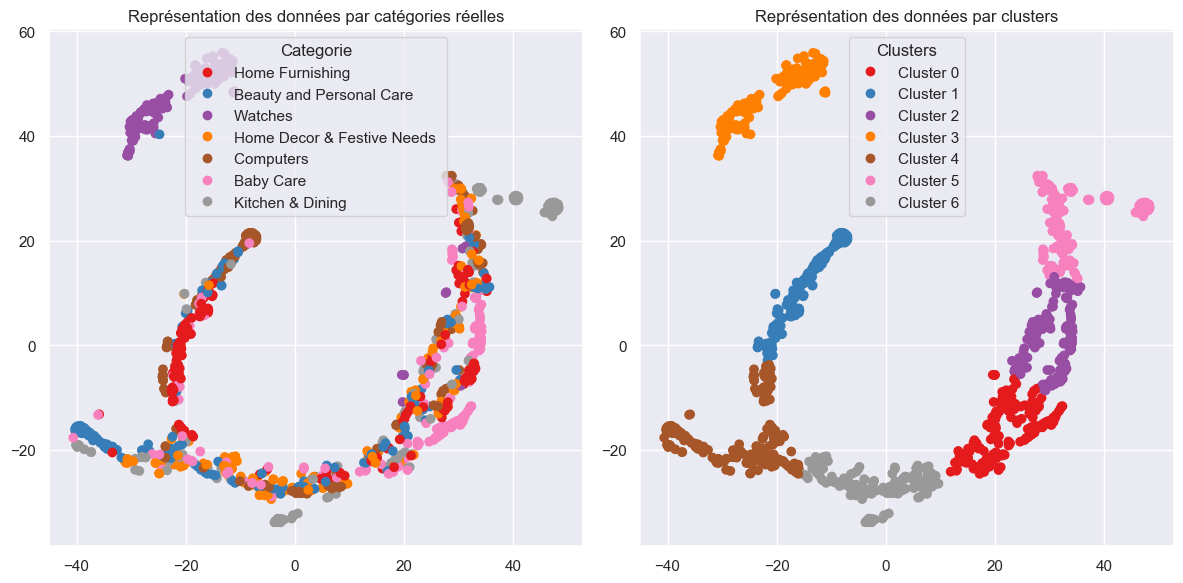

ARI : 0.2049


In [54]:
TSNE_visu_fct(X_tsne, y_categories_numeric, cluster_labels, ARI, list_categories)

Les résultats ne sont pas réellement bons avec les paramètres que l'on a assigné à nos variables/paramètres. Le but est que le graphique de gauche se rapporche le plus possible de droite.

Mais on voit pas mal de données se mélanger, ce qui est normal avec un ARI de 0.20.

### 3.3.2 BERT

#### 3.3.2.1 Fonctions du modèle

In [55]:
def prepare_bert_input_fct(sentences, bert_tokenizer, max_length=128):
    # Initialisation de listes pour stocker les tenseurs générés
    input_ids = []
    token_type_ids = []
    attention_mask = []

    # Boucle pour chaque phrase pour la tokeniser et préparer les entrées pour BERT
    for sent in sentences:
        bert_inputs = bert_tokenizer.encode_plus(
            sent,  # Texte à encoder
            add_special_tokens=True,  # Ajout de tokens spéciaux pour BERT
            max_length=max_length,  # Longueur maximale des phrases
            padding='max_length',  # Compléter les phrases courtes avec des tokens de padding
            return_attention_mask=True,  # Générer un masque d'attention
            return_token_type_ids=True,  # Générer des identifiants de type de token
            truncation=True  # Tronquer les phrases trop longues
        )

        input_ids.append(bert_inputs['input_ids'])
        attention_mask.append(bert_inputs["attention_mask"])
        token_type_ids.append(bert_inputs['token_type_ids'])

    # Convertir les listes en tenseurs PyTorch
    input_ids = torch.tensor(input_ids)
    token_type_ids = torch.tensor(token_type_ids)
    attention_mask = torch.tensor(attention_mask)

    return input_ids, token_type_ids, attention_mask

In [56]:
def extract_feature_bert_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    # Taille des lots pour le traitement
    batch_size = b_size
    
    # Taille des lots pour la prédiction
    batch_size_pred = b_size
    
    # Chargement du tokenizer
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    
    time1 = time.time()

    # Parcour les phrases par lots
    for step in range(len(sentences) // batch_size):
        # Indice de départ pour le lot actuel
        idx = step * batch_size

        # Prépare les entrées BERT pour le lot
        input_ids, token_type_ids, attention_mask = prepare_bert_input_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        # Prédiction avec le modèle Hugging Face
        if mode=='HF': 
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            last_hidden_states = outputs.last_hidden_state

        # Prédictionb avec le modèle TensorFlow Hub
        if mode=='TFhub':
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        # Stockage des états cachés dans une matrice
        if step == 0: # Initialisation lors du premier lot
            last_hidden_states_tot = last_hidden_states.detach().numpy()
        else: # Concaténation des résultats pour les lots suivants
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states.detach().numpy()), axis=0)

    # Moyenne des couches cachées pour créer des embeddings de phrase
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print(time2)
     
    return features_bert, last_hidden_states_tot

#### 3.3.2.2 Execution du modèle

In [57]:
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

sentences = df['filtered_text'].to_list()

features_bert, last_hidden_states = extract_feature_bert_fct(model, model_type='bert-base-uncased', sentences=sentences, max_length=128, b_size=16)
print(features_bert.shape)

ImportError: 
BertModel requires the PyTorch library but it was not found in your environment.
However, we were able to find a TensorFlow installation. TensorFlow classes begin
with "TF", but are otherwise identically named to our PyTorch classes. This
means that the TF equivalent of the class you tried to import would be "TFBertModel".
If you want to use TensorFlow, please use TF classes instead!

If you really do want to use PyTorch please go to
https://pytorch.org/get-started/locally/ and follow the instructions that
match your environment.


In [ ]:
valid_sentences = [sent for sent in sentences if len(sent.strip()) > 0]

# Relancer les embeddings sur les phrases filtrées
features_bert, _ = extract_feature_bert_fct(
    model,
    model_type='bert-base-uncased',
    sentences=valid_sentences,
    max_length=128,
    b_size=16
)
print(features_bert.shape)

In [ ]:
filtered_categories = [y_categories_numeric[i] for i in range(len(sentences)) if len(sentences[i].strip()) > 0]
print(f"Longueur des catégories filtrées : {len(filtered_categories)}")

In [ ]:
# Trouver les indices des phrases valides
valid_indices = [i for i in range(len(sentences)) if len(sentences[i].strip()) > 0]

# Vérifier s'il y a un désalignement entre les phrases valides et les embeddings
if len(valid_indices) != len(features_bert):
    print(f"Nombre d'indices valides : {len(valid_indices)}")
    print(f"Nombre d'embeddings générés : {len(features_bert)}")

In [ ]:
# Filtrer les catégories pour qu'elles correspondent aux embeddings
filtered_categories_aligned = [y_categories_numeric[i] for i in valid_indices[:len(features_bert)]]
print(f"Longueur des catégories alignées : {len(filtered_categories_aligned)}")

In [ ]:
ARI, X_tsne, cluster_labels = ARI_fct(features_bert, filtered_categories_aligned, num_clusters)
print(ARI)

#### 3.3.2.3 Visualisation du modèle

In [ ]:
TSNE_visu_fct(X_tsne, filtered_categories_aligned, cluster_labels, ARI, list_categories)

### 3.3.3 Universal Sentence Encoder (USE)

In [58]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [59]:
def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()
    features = []

    for step in range(0, len(sentences), batch_size):
        batch_sentences = sentences[step:step + batch_size]

        feat = embed(batch_sentences).numpy()

        features.append(feat)

    features = np.vstack(features)
    
    time2 = np.round(time.time() - time1, 0)
    print(time2)
    print(features.shape)
    
    return features

In [60]:
batch_size = 10
sentences = df['filtered_text'].to_list()

features_USE = feature_USE_fct(sentences, batch_size)

1.0
(1050, 512)


In [61]:
num_clusters = len(list_categories)
ARI, X_tsne, cluster_labels = ARI_fct(features_USE, y_categories_numeric, num_clusters)
print(ARI)

ARI : 0.4107 - Time : 10.0s
0.4107


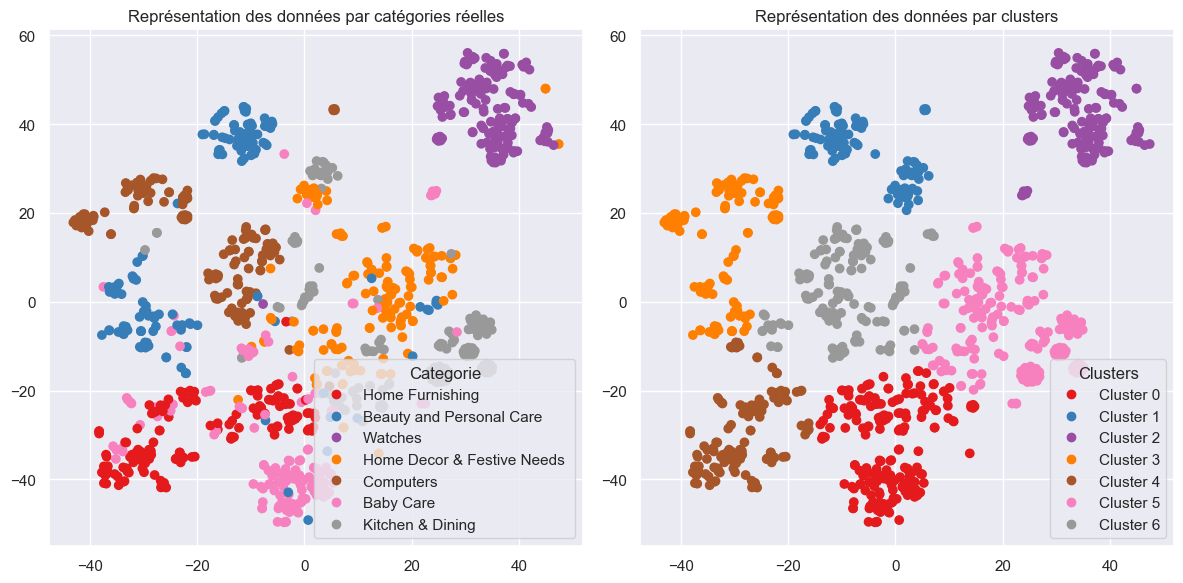

ARI : 0.4107


In [62]:
TSNE_visu_fct(X_tsne, y_categories_numeric, cluster_labels, ARI, list_categories)

Ces trois modèles (Word2Vec / BERT(Hugging Face) / USE) nous démontrent qu'une partie des données peut être plus facilement séparé que le reste, notamment les montres.

Certaines catégories peuvent se retrouver mélangées (en référence à leurs sous-catégories) comme par exemple Baby Care et Home Furnishing. 

BERT nous a également montré un temps d'exécution bien plus long par rapport à ces deux homologues (quelques secondes contre une minute pour BERT).

In [64]:
df_images = df[['uniq_id', 'product_name', 'image',
               'category_level_1', 'category_level_2', 'category_level_3',
               'category_level_4', 'category_level_5', 'category_level_6',
               'category_level_7', 'filtered_text']]

In [65]:
df_images.to_csv('data/df_images.csv', sep=";", index=False, encoding='utf-8-sig')